### Imports

In [72]:
# Import coastline distance function from helper file
from pathlib import Path
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [73]:
from calculate_distance_coastline import get_distance_to_coast_ddm
from calculate_ocean import is_ocean

In [74]:
data_path = Path("../data\processed\earthquake_data_tsunami_validated.csv")
data_df = pd.read_csv(data_path)

### Latitude and longitude were not meaningful earlier. We should create a meaningful location based feature.
This notebook begins by wiring in the coastline distance function so we can derive a new feature: the distance (in km) from each event to the nearest coastline. We’ll import the function from our helper module and get it ready for use in later steps.

In [75]:
# If the point is not in ocean, calculate distance to coastline
data_df["distance_to_coast_km"] = data_df.apply(lambda r: get_distance_to_coast_ddm(r["latitude"], r["longitude"]) if not is_ocean(r["latitude"], r["longitude"]) else 0, axis=1)
data_df.head()

,magnitude,cdi,mmi,sig,nst,dmin,gap,depth,latitude,longitude,Year,Month,tsunami,distance_to_coast_km
0,7.0,8,7,768,117,0.509,17.0,14.000,-9.7963,159.596,2022,11,0,0.0
1,6.9,4,4,735,99,2.229,34.0,25.000,-4.9559,100.738,2022,11,0,0.0
2,7.0,3,3,755,147,3.125,18.0,579.000,-20.0508,-178.346,2022,11,0,0.0
3,7.3,5,5,833,149,1.865,21.0,37.000,-19.2918,-172.129,2022,11,0,0.0
4,6.6,0,2,670,131,4.998,27.0,624.464,-25.5948,178.278,2022,11,0,0.0


### Now we can explore this feature further.

In [76]:
mean_distance = data_df.groupby("tsunami")["distance_to_coast_km"].mean()
print(mean_distance.values)


[106.62364588   8.26517428]


### Mean values show significant difference between classes.

In [77]:
# correlation between distance to coast and tsunami occurrence
print(data_df.corr()["tsunami"]["distance_to_coast_km"])

-0.13999074026198058


### As expected there is a meaningful negative correlation.

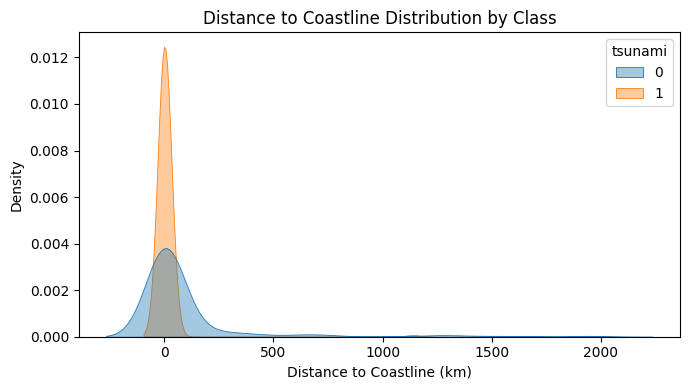

In [78]:
fig, ax = plt.subplots(figsize=(7,4))
sns.kdeplot(
    data=data_df,
    x="distance_to_coast_km",
    hue="tsunami",
    common_norm=False,
    fill=True,
    alpha=0.4,
    linewidth=0.6,
    ax=ax
)
ax.set_title("Distance to Coastline Distribution by Class")
ax.set_xlabel("Distance to Coastline (km)")

plt.tight_layout()
plt.show()

This plot shows that the tsunamis happen where distance to coastline is low. Now we can remove 'latitude' and 'longitude' columns from our data

In [79]:
data_df = data_df.drop(columns=["latitude", "longitude"])

### Using the time features.
In the current data, the 'Year' and 'Month' columns are not a good identifier for detecting tsunamis. Thus we will try to create better time features. Since earthquakes can trigger other earthquakes in a linear time-line, we can create a new column called 'month_number'.

In [80]:
if ("Year" not in data_df.columns) or ("Month" not in data_df.columns):
    dt_col = next((c for c in ["time","date","datetime"] if c in data_df.columns), None)
    dt = pd.to_datetime(data_df[dt_col], errors="coerce")
    data_df["Year"] = dt.dt.year
    data_df["Month"] = dt.dt.month

data_df["month_number"] = (data_df["Year"] - 2000) * 12 + data_df["Month"]

print(data_df[["Year","Month","month_number"]].head())

   Year  Month  month_number
0  2022     11           275
1  2022     11           275
2  2022     11           275
3  2022     11           275
4  2022     11           275


In [81]:
# Check correlation of month_number with tsunami
work_df = data_df[["month_number", "Year", "Month", "tsunami"]].dropna().copy()
work_df["tsunami"] = work_df["tsunami"].astype(int)
corr_month_number = work_df[["month_number", "tsunami"]].corr().iloc[0,1]
print(f"Correlation month_number-tsunami: {corr_month_number:.4f}")

Correlation month_number-tsunami: -0.0943


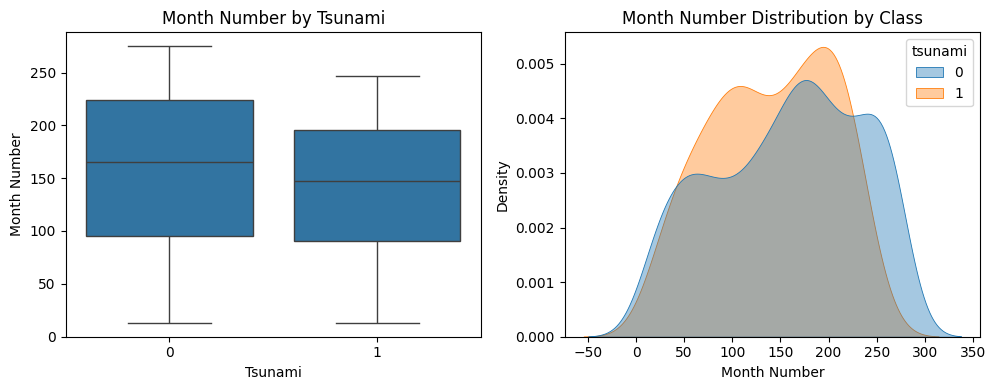

In [82]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
sns.boxplot(data=data_df, x='tsunami', y='month_number', ax=ax[0])
ax[0].set_title('Month Number by Tsunami'); ax[0].set_xlabel('Tsunami'); ax[0].set_ylabel('Month Number')

sns.kdeplot(data=data_df, x='month_number', hue='tsunami', common_norm=False, fill=True, alpha=0.4, linewidth=0.6, ax=ax[1])
ax[1].set_title('Month Number Distribution by Class'); ax[1].set_xlabel('Month Number')

plt.tight_layout()
plt.show()

Still there is no meaningful insight using time features. Time is redundant for determining the tsunamis. So we can remove the time features from our data.

In [83]:
data_df = data_df.drop(columns=["Year", "Month","month_number"])
data_df.head()

,magnitude,cdi,mmi,sig,nst,dmin,gap,depth,tsunami,distance_to_coast_km
0,7.0,8,7,768,117,0.509,17.0,14.000,0,0.0
1,6.9,4,4,735,99,2.229,34.0,25.000,0,0.0
2,7.0,3,3,755,147,3.125,18.0,579.000,0,0.0
3,7.3,5,5,833,149,1.865,21.0,37.000,0,0.0
4,6.6,0,2,670,131,4.998,27.0,624.464,0,0.0


### In EDA we have observed that dmin and nst features were not properly set.
Since half ot the data points that belongs to nst and dmin are not set correctly, we have to drop those columns.

In [84]:
data_df = data_df.drop(columns=["dmin", "nst"])
data_df.head()

,magnitude,cdi,mmi,sig,gap,depth,tsunami,distance_to_coast_km
0,7.0,8,7,768,17.0,14.000,0,0.0
1,6.9,4,4,735,34.0,25.000,0,0.0
2,7.0,3,3,755,18.0,579.000,0,0.0
3,7.3,5,5,833,21.0,37.000,0,0.0
4,6.6,0,2,670,27.0,624.464,0,0.0


### We have decided which columns should be in the data. Next step is to normalize the data. We should inspect the data and choose the suitable normalization method.

--- Descriptive Statistics ---
                      count        mean         std    min    25%      50%  \
magnitude             782.0    6.941125    0.445514    6.5    6.6    6.800   
cdi                   782.0    4.333760    3.169939    0.0    0.0    5.000   
mmi                   782.0    5.964194    1.462724    1.0    5.0    6.000   
sig                   782.0  870.108696  322.465367  650.0  691.0  754.000   
depth                 782.0   75.883199  137.277078    2.7   14.0   26.295   
distance_to_coast_km  782.0   85.367148  289.372434    0.0    0.0    0.000   

                             75%      max  
magnitude               7.100000     9.10  
cdi                     7.000000     9.00  
mmi                     7.000000     9.00  
sig                   909.750000  2910.00  
depth                  49.750000   670.81  
distance_to_coast_km    6.544922  1971.00  


--- Generating Feature Plots ---


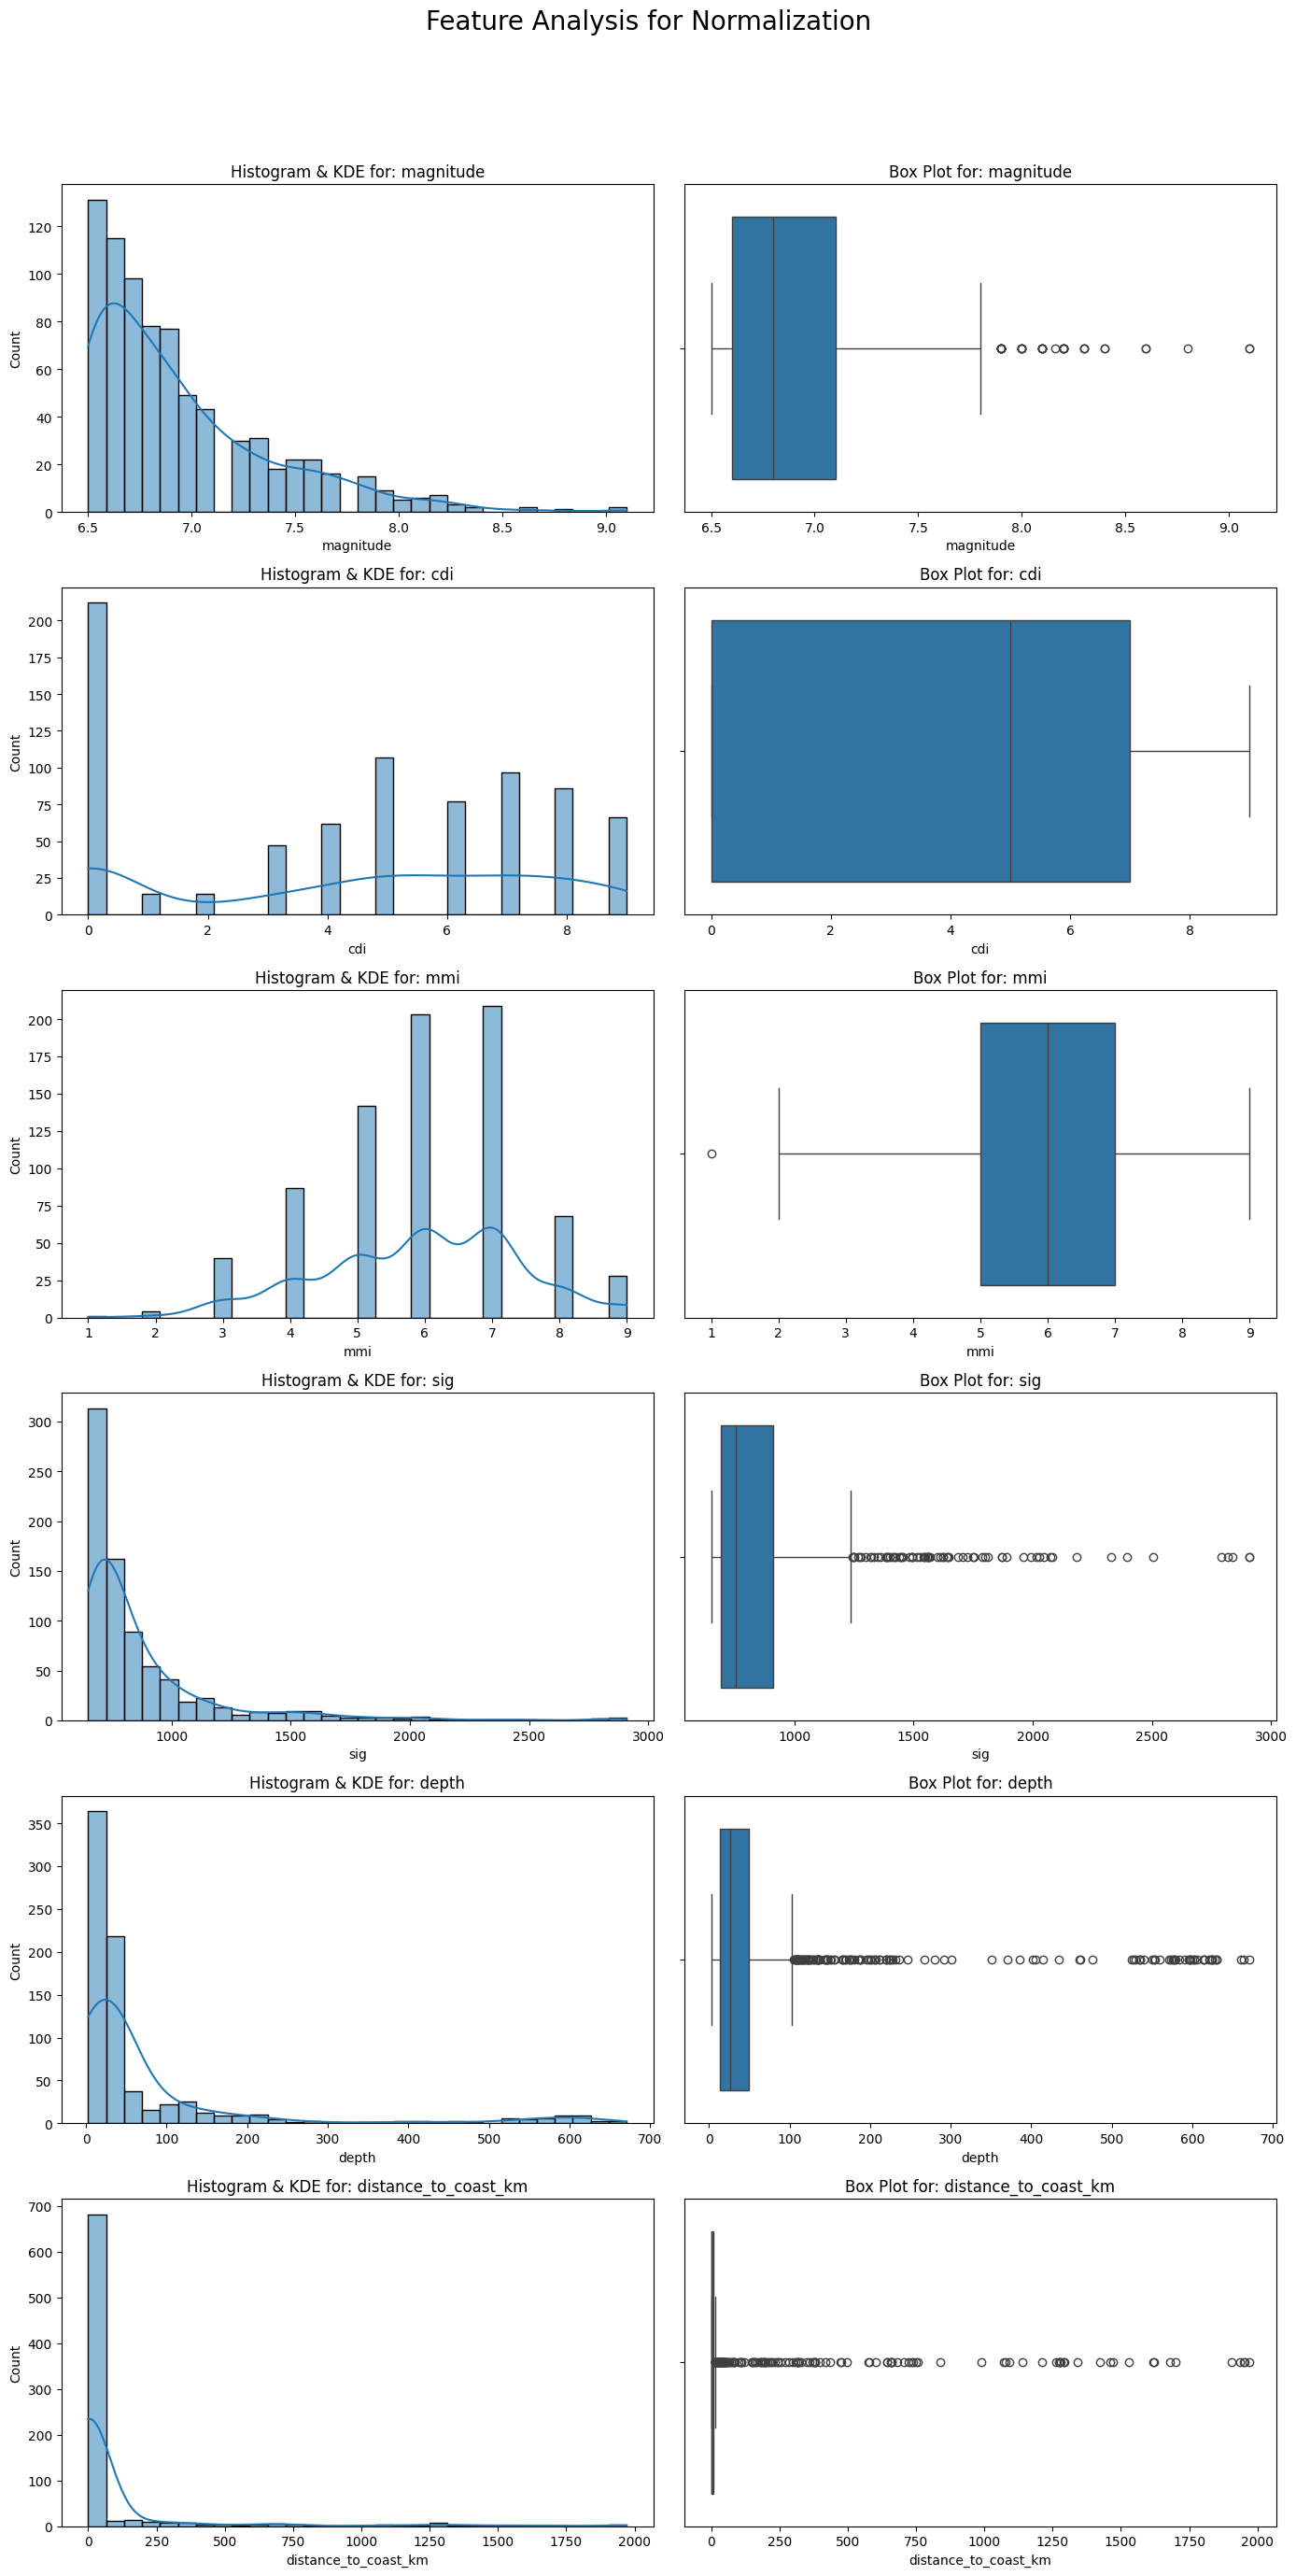

In [85]:
features_to_scale = [
    'magnitude', 
    'cdi', 
    'mmi', 
    'sig', 
    'depth', 
    'distance_to_coast_km'
]
n_features = len(features_to_scale)

print("--- Descriptive Statistics ---")

print(data_df[features_to_scale].describe().T)
print("\n" + "="*30 + "\n")

print("--- Generating Feature Plots ---")

fig, axes = plt.subplots(n_features, 2, figsize=(14, n_features * 4.5))
fig.suptitle('Feature Analysis for Normalization', fontsize=20, y=1.02)

for i, feature in enumerate(features_to_scale):
    
    sns.histplot(data_df[feature], kde=True, ax=axes[i, 0], bins=30)
    axes[i, 0].set_title(f'Histogram & KDE for: {feature}')
    
    sns.boxplot(x=data_df[feature], ax=axes[i, 1])
    axes[i, 1].set_title(f'Box Plot for: {feature}')

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

Based on the descriptive statistics, a single scaling method is insufficient. The data exhibits two main challenges:

Extreme Right-Skew & Meaningful Outliers: Columns like depth (Mean: 75.8 vs. Median: 26.2) and sig (Max: 2910 vs. 75th %: 909) are heavily skewed. These outliers are meaningful and should not be discarded, but they will "squash" standard linear scalers.

Meaningful Zeros: Columns distance_to_coast_km (Median: 0.0) and cdi (25th %: 0.0) are "zero-inflated," where 0 is a significant value (e.g., "in the ocean") that must be preserved.

The Solution: Two-Step Pipeline
We will apply a two-step Pipeline to all feature columns using a ColumnTransformer. This approach preserves the information from the entire dataset, including outliers and zeros, while making it suitable for a machine learning model.

Step 1: PowerTransformer(method='yeo-johnson')

This is a non-linear transformation that makes the data more Gaussian (bell-shaped).

It "pulls in" the extreme outliers (like 2910 in sig) without ignoring them, solving the skewness problem.

The 'yeo-johnson' method is specifically chosen because it can handle the meaningful zero values in distance_to_coast_km and cdi correctly.

Step 2: StandardScaler()

After the PowerTransformer has normalized the distribution, we can safely apply StandardScaler to center the data at a mean of 0 and a standard deviation of 1.

The tsunami column (the target variable) will be left untouched.

In [ ]:
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

features_to_transform = [
    'magnitude', 
    'cdi', 
    'mmi', 
    'sig', 
    'depth', 
    'distance_to_coast_km'
]

feature_pipeline = Pipeline(steps=[
    ('power_transform', PowerTransformer(method='yeo-johnson')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('transform_and_scale', feature_pipeline, features_to_transform)
    ],
    remainder='passthrough'  # This is crucial: it leaves 'tsunami' alone
)

scaled_data = preprocessor.fit_transform(data_df)

passthrough_features = [col for col in data_df.columns 
                        if col not in features_to_transform]

final_columns = features_to_transform + passthrough_features

scaled_df = pd.DataFrame(scaled_data, columns=final_columns)

--- Original Data ---
   magnitude  cdi  mmi  sig   gap    depth  tsunami  distance_to_coast_km
0        7.0    8    7  768  17.0   14.000        0                   0.0
1        6.9    4    4  735  34.0   25.000        0                   0.0
2        7.0    3    3  755  18.0  579.000        0                   0.0
3        7.3    5    5  833  21.0   37.000        0                   0.0
4        6.6    0    2  670  27.0  624.464        0                   0.0




In [93]:
print("--- TRANSFORMED AND SCALED DATA ---")
scaled_df.head()

--- TRANSFORMED AND SCALED DATA ---


,magnitude,cdi,mmi,sig,depth,distance_to_coast_km,gap,tsunami
0,0.4,0.428571,0.5,0.064000,-0.343916,0.0,17.0,0.0
1,0.2,-0.142857,-1.0,-0.086857,-0.036224,0.0,34.0,0.0
2,0.4,-0.285714,-1.5,0.004571,15.460280,0.0,18.0,0.0
3,1.0,0.000000,-0.5,0.361143,0.299441,0.0,21.0,0.0
4,-0.4,-0.714286,-2.0,-0.384000,16.732000,0.0,27.0,0.0
